In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
import sys
% matplotlib inline

In [99]:
fname = '200625//200625_Bi2Ye30617_3w_1.txt'
#fname = '210326//210326_Bi2Te3_p5_3w_vac_1.txt'
#fname = '210623//210623_Bi2Te3_p11_1mm_3w_1.txt'
#fname = '210630//210630_Bi2Te3_p11_2mm_3w_1.txt'
df = pd.read_csv(fname, sep = ' ')

In [100]:
df = df.set_index('Time')

In [101]:
df['Lockin1f'][df['Y3'].idxmax()]

0.3981

,Date_time,TC,SENS,Lockin1f,Lockin2f,X3,Y3,X3_ref,Y3_ref
Time,,,,,,,,,
1926.090166,13:09:19.267001,15,21,0.0100,0.0091,-0.000872,0.000024,0.000168,-0.000005
3811.369998,13:40:44.547833,15,21,0.0158,0.0157,-0.000881,0.000035,0.000163,-0.000007
5676.636685,14:11:49.813520,15,21,0.0251,0.0250,-0.000876,0.000051,0.000163,-0.000010
7561.912517,14:43:15.088351,15,21,0.0398,0.0397,-0.000875,0.000081,0.000161,-0.000016
9407.154059,15:14:00.330893,15,21,0.0631,0.0631,-0.000862,0.000127,0.000159,-0.000023


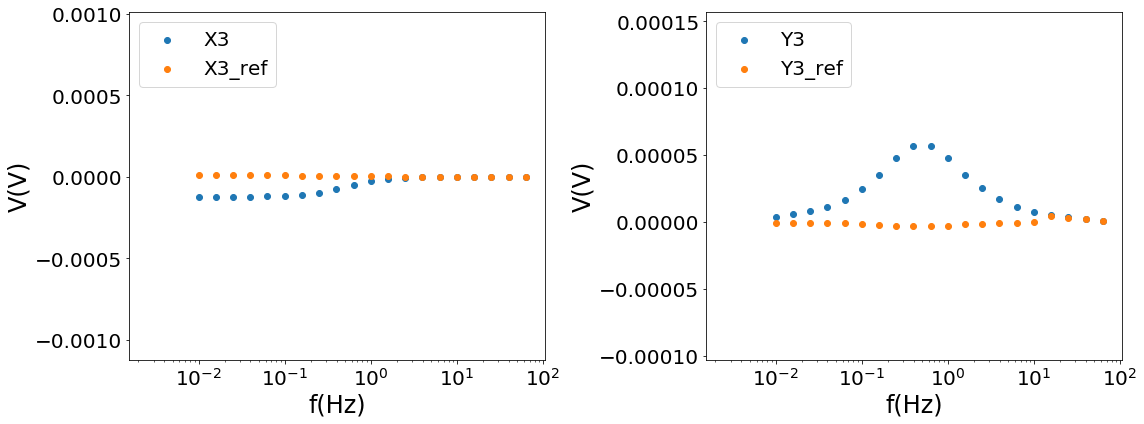

In [64]:
fig, axs = plt.subplots(1, 2, figsize = (16,6))
fz = 24

axs[0].scatter(df.Lockin1f, df.X3, label = 'X3')
axs[0].scatter(df.Lockin1f, df.X3_ref, label = 'X3_ref')
axs[0].set_xlabel('f(Hz)', fontsize = fz)
axs[0].set_ylabel('V(V)', fontsize = fz)
axs[0].set_xscale('log')
#axs[0].set_xlim(0.01,1000)
axs[0].legend(loc = 'upper left', fontsize = 20)
axs[0].tick_params(labelsize = 20)
#axs[0].set_ylim(df.X3.min() - 10e-6, df.X3.max() + 10e-6)
axs[0].set_ylim(min(df.X3_ref.min(),df.X3.min()) - 1000e-6, max(df.X3_ref.max(),df.X3.max()) + 1000e-6)
axs[1].scatter(df.Lockin1f, df.Y3, label = 'Y3')
axs[1].scatter(df.Lockin1f, df.Y3_ref, label = 'Y3_ref')
axs[1].set_xlabel('f(Hz)', fontsize = fz)
axs[1].set_ylabel('V(V)', fontsize = fz)
axs[1].set_xscale('log')
#axs[1].set_xlim(0.01,1000)
axs[1].tick_params(labelsize = 20)
axs[1].legend(loc = 'upper left', fontsize = 20)
axs[1].set_ylim(min(df.Y3_ref.min(),df.Y3.min()) - 100e-6, max(df.Y3_ref.max(),df.Y3.max()) + 100e-6)
#plt.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.tight_layout()
#fig.savefig(fname[:-4] + '_raw.jpg', dpi = 100)

In [15]:
help(df.min)

Help on method min in module pandas.core.frame:

min(axis=None, skipna=None, level=None, numeric_only=None, **kwargs) method of pandas.core.frame.DataFrame instance
    This method returns the minimum of the values in the object.
                If you want the *index* of the minimum, use ``idxmin``. This is
                the equivalent of the ``numpy.ndarray`` method ``argmin``.
    
    Parameters
    ----------
    axis : {index (0), columns (1)}
    skipna : boolean, default True
        Exclude NA/null values. If an entire row/column is NA, the result
        will be NA
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a Series
    numeric_only : boolean, default None
        Include only float, int, boolean columns. If None, will attempt to use
        everything, then use only numeric data. Not implemented for Series.
    
    Returns
    -------
    min : Series or DataFrame 

In [113]:
alpha = 0.0062842#0.0062842#0.0065321  ##0.0048331#0.0048375 #0.0048331#temperature coefficient
Rref = 10.029#3.006829724
V_input = 0.9 #0.9#0.7  ##1.1
X1 = 0.130601 #0.130601 #0.13939   ##0.0591204#0.0443347
X1_ref = 0.105095#0.105095#0.0741048  ##0.0572512#0.047478
I1w = X1_ref / Rref
Re0 = Rref * X1 / X1_ref #sample resistance at 0 current
l = 8e-3/2 #4e-3/2#half length of wire(= half gap width)
width = 2.3e-3 #2.3e-3 #1.3e-3; #mm line width --
#thickness = 100e-6  ##43.2375e-6#15.12e-6 #um line thickness --
#S = width * thickness  #crosssectional area
rou =  7.74e3 #kg/m^3 density

#for suspended wire, only gap region is 3w bearing part (4pt resistance)
R2pt = 22.31
correction_factor = 1 - Re0 / (50 + Rref + R2pt) # 1 - R_all_3w_parts / R_total
correction_factor

0.8486381278088394

In [11]:
Re0#P-11-1mm

18.864396233442367

In [24]:
Re0#P-11-2mm

12.46298519434797

In [41]:
def X3_calc(f1, k, cp):
    w1 = 2 * np.pi * f1
    kappa = k / (rou * cp)
    tau = 4 * l**2 / kappa
    X3 = - alpha * Re0**2 * I1w**3 * l / (12 * k * S) * (1 / (1 + (w1 * tau / 5)**2)) * correction_factor
    return X3
def Y3_calc(f1, k, cp):
    w1 = 2 * np.pi * f1
    kappa = k / (rou * cp)
    tau = 4 * l**2 / kappa
    Y3 = alpha * Re0**2 * I1w**3 * l / (12 * k * S) * ((w1 * tau / 5) / (1 + (w1 * tau / 5)**2)) * correction_factor
    return Y3
def X3_Y3_fit(fcombo, k, cp):
    X3 = X3_calc(fcombo[:int(len(fcombo) / 2)], k, cp)
    Y3 = Y3_calc(fcombo[int(len(fcombo) / 2):], k, cp)
    return np.concatenate([X3,Y3])

In [103]:
def X3_calc(f1, kt, k_cp):
    w1 = 2 * np.pi * f1
    kappa = k_cp / rou
    tau = 4 * l**2 / kappa
    X3 = - alpha * Re0**2 * I1w**3 * l / (12 * kt * width) * (1 / (1 + (w1 * tau / 5)**2)) * correction_factor
    return X3
def Y3_calc(f1, kt, k_cp):
    w1 = 2 * np.pi * f1
    kappa = k_cp / rou
    tau = 4 * l**2 / kappa
    Y3 = alpha * Re0**2 * I1w**3 * l / (12 * kt * width) * ((w1 * tau / 5) / (1 + (w1 * tau / 5)**2)) * correction_factor
    return Y3
def X3_Y3_fit(fcombo, kt, k_cp):
    X3 = X3_calc(fcombo[:int(len(fcombo) / 2)], kt, k_cp)
    Y3 = Y3_calc(fcombo[int(len(fcombo) / 2):], kt, k_cp)
    return np.concatenate([X3,Y3])

In [13]:
help(curve_fit)

Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like or object
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, but can actually be any object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
        Initial guess for the parameters (length N).  If None, then the
        init

In [115]:
xdata = np.concatenate([df['Lockin1f'], df['Lockin1f']])
ydata = np.concatenate([df['X3'], df['Y3']])
popt, pcov = curve_fit(X3_Y3_fit, xdata, ydata, p0 = [2, 2])

In [111]:
popt,pcov #test


(array([0.00056958, 0.07898489]), array([[5.34953940e-12, 7.41830913e-10],
        [7.41830913e-10, 8.55559012e-07]]))

In [27]:
# mask = df['Lockin1f'] > 0.1
# xdata = np.concatenate([df['Lockin1f'][mask], df['Lockin1f'][mask]])
# ydata = np.concatenate([df['X3'][mask], df['Y3'][mask]])
# popt, pcov = curve_fit(X3_Y3_fit, xdata, ydata, p0 = [2, 100])

In [17]:
#P-11-1mm with correction factor
popt,pcov

(array([2.08273686e-04, 2.70383964e-01]),
 array([[8.48305763e-14, 1.10128293e-10],
        [1.10128293e-10, 1.14463283e-06]]))

In [26]:
#P-11-1mm no correction factor
popt,pcov

(array([0.00027372, 0.27038395]), array([[1.46524847e-13, 1.44736230e-10],
        [1.44736230e-10, 1.14462642e-06]]))

In [27]:
#P-11-2mm with correction factor
popt,pcov

(array([4.22245736e-04, 4.57182423e-01]),
 array([[2.84519645e-11, 3.08063550e-08],
        [3.08063550e-08, 3.02033180e-04]]))

In [16]:
#P-11-2mm no correction factor
popt,pcov

(array([0.00049756, 0.45718127]), array([[3.95062349e-11, 3.63002086e-08],
        [3.63002086e-08, 3.02020978e-04]]))

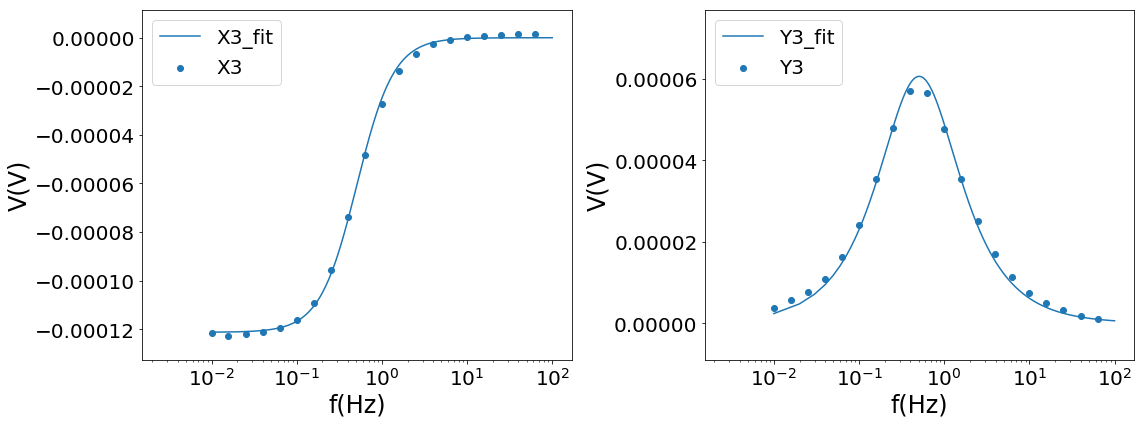

In [116]:
fig, axs = plt.subplots(1, 2, figsize = (16,6))
fz = 24

f1 = np.arange(0.01, 100.01, 0.01)

axs[0].scatter(df.Lockin1f, df.X3, label = 'X3')
#axs[0].scatter(df.Lockin1f, df.X3_ref, label = 'X3_ref')
#axs[0].scatter(df2.Lockin1f, df2.X3, label = 'X3 test2 (measured next day)')#
#axs[0].scatter(df2.Lockin1f, df2.X3_ref, label = 'X3_ref test2')
axs[0].plot(f1, X3_calc(f1,*popt), label = 'X3_fit')
axs[0].set_xlabel('f(Hz)', fontsize = fz)
axs[0].set_ylabel('V(V)', fontsize = fz)
axs[0].set_xscale('log')
#axs[0].set_xlim(0.01,1000)
axs[0].legend(loc = 'upper left', fontsize = 20)
axs[0].tick_params(labelsize = 20)
axs[0].set_ylim(df.X3.min() - 10e-6, df.X3.max() + 10e-6)

axs[1].scatter(df.Lockin1f, df.Y3, label = 'Y3')
#axs[1].scatter(df.Lockin1f, df.Y3_ref, label = 'Y3_ref')
#axs[1].scatter(df2.Lockin1f, df2.Y3, label = 'X3 test2')
#axs[1].scatter(df2.Lockin1f, df2.Y3_ref, label = 'X3_ref test2')
axs[1].plot(f1, Y3_calc(f1, *popt), label = 'Y3_fit')
axs[1].set_xlabel('f(Hz)', fontsize = fz)
axs[1].set_ylabel('V(V)', fontsize = fz)
axs[1].set_xscale('log')
#axs[1].set_xlim(0.01,1000)
axs[1].tick_params(labelsize = 20)
axs[1].legend(loc = 'upper left', fontsize = 20)
axs[1].set_ylim(df.Y3.min() - 10e-6, df.Y3.max() + 20e-6)
#axs[1].text(0.6,0.8, f"fitted k = {round(popt[0],2)} W/mK\nfitted cp = {round(popt[1],2)} J/kgK", 
#            fontsize = 14, transform=axs[1].transAxes)

#plt.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.tight_layout()
#fig.savefig(fname[:-4] + '_fit.jpg', dpi = 300)

In [117]:
f1[np.argmax(Y3_calc(f1, *popt))]

0.51

## help(plt.legend)

In [75]:
help(np.amax)

Help on function amax in module numpy:

amax(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)
    Return the maximum of an array or maximum along an axis.
    
    Parameters
    ----------
    a : array_like
        Input data.
    axis : None or int or tuple of ints, optional
        Axis or axes along which to operate.  By default, flattened input is
        used.
    
        .. versionadded:: 1.7.0
    
        If this is a tuple of ints, the maximum is selected over multiple axes,
        instead of a single axis or all the axes as before.
    out : ndarray, optional
        Alternative output array in which to place the result.  Must
        be of the same shape and buffer length as the expected output.
        See `ufuncs-output-type` for more details.
    
    keepdims : bool, optional
        If this is set to True, the axes which are reduced are left
        in the result as dimensions with size one. With this option,
        the result will